# Perth Weather Consumer

In [31]:
# import statements
import datetime as dt
from time import sleep
from kafka import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt
from json import loads
import datetime
import statistics
from collections import Counter

# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

In [6]:
# Define the topic name
topic = "Perth"

def connect_kafka_consumer():
    _consumer = None
    
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=100000, # stop iteration if no message after 100 sec
                                   auto_offset_reset='latest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['localhost:9092'],
                                   value_deserializer = lambda x: loads(x.decode("ascii")),
                                   api_version=(0, 10))
    
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    
    finally:
        return _consumer    

In [28]:
def init_plots():
    
    try:
        # Create empty plot with the predefined width and height
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height))
        fig.subplots_adjust(hspace=0.8)
        
        # Create one plot and define the x and y label
        ax1 = fig.add_subplot(211)
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Temperature')
                
        ax2 = fig.add_subplot(212)
        ax2.set_xlabel('WeatherText')
        ax2.set_ylabel('Count')
        
        # giving figure a title        
        fig.suptitle('Weather in Perth')         
        # displaying the figure
        fig.show() 
        # drawing on the canvas
        fig.canvas.draw() 
        
        return fig, ax1, ax2
    
    except Exception as ex:
        print(str(ex))    

In [61]:
def find_top_frequent(a_list, top_frequency):
    
    a_dict = Counter(a_list)
    
    sorted_list = sorted(a_dict.items(), key = lambda x: x[1], reverse=True)
    
    threshold = sorted_list[:top_frequency][-1][1]
    
#     print("new data")
#     print(sorted_list)
#     print(threshold)
    
    sorted_dict = []
    
    for i in sorted_list:
        if i[1] < threshold: 
            break
        else:
            sorted_dict.append(i)
    
    sorted_dict = dict(sorted_dict)
    
#     print(sorted_dict)
            
    return sorted_dict    

<IPython.core.display.Javascript object>


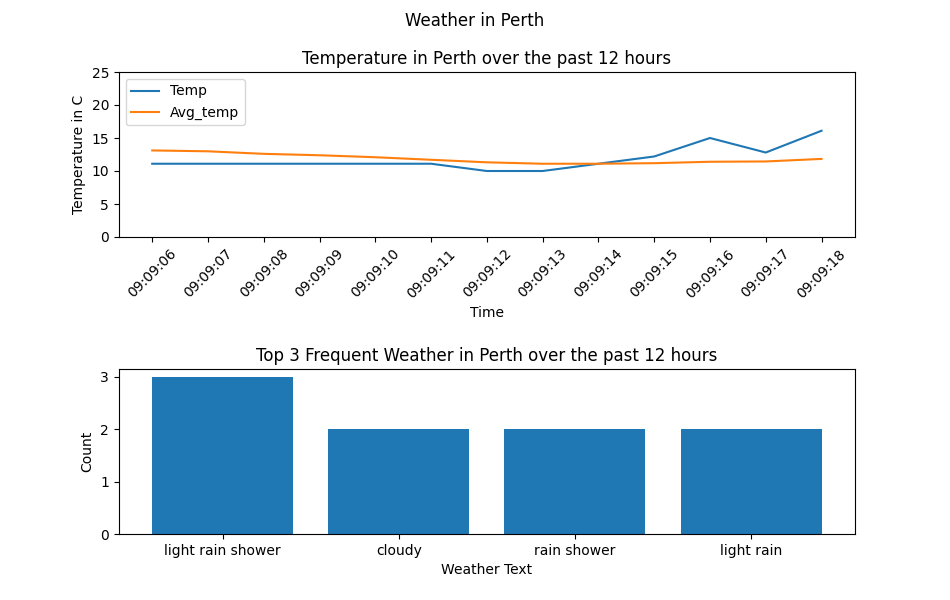

<ipython-input-71-ed7c7342042d>:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x, rotation=45)


KeyboardInterrupt: 

In [71]:
def consume_messages(consumer,fig, ax1, ax2):
    try:
        # container for x and y values
        x, y1, y2 = [], [], []
        X = []
        
        for message in consumer:
            
            x_limit = 12
            top_frequency = 3
            
#             print(message)
            
#             x.append(datetime.datetime.fromtimestamp(message.timestamp / 1e3))
#             x.append(datetime.datetime.strptime(message.value["LocalObservationDateTime"], "%Y-%m-%dT%H:%M:%S.%f"))
            
#             x.append(datetime.datetime.strptime(message.value["LocalObservationDateTime"][:25], "%Y-%m-%dT%H:%M:%S.%f"))
#             x.append(datetime.datetime.fromtimestamp(message.value["EpochTime"]).time())
#             a = datetime.datetime.fromtimestamp(message.value["EpochTime"]).time()
#             print(a)
#             b = datetime.datetime.fromtimestamp(message.value["EpochTime"])
#             print(b)
            
#             b = datetime.datetime.strptime()
#             print(a)
#             x.append(a)
#             x.append(datetime.datetime.fromtimestamp(message.value["EpochTime"]))

            x.append(message.value["Time"])
            y1.append(message.value["Temperature"]["Metric"]["Value"])
            
            X.append(message.value["WeatherText"])
            X = [each_X.strip().lower() for each_X in X]            
            X_dict = find_top_frequent(X, top_frequency)

                
            if len(y1) > 1:
                y2.append(statistics.mean(y1[:len(y1)]))
            else:
                y2.append(0)
            
            # Plot graph
            if len(x) > x_limit:
                
                ax1.clear()
                ax1.plot(x,y1, label = "Temp")
                ax1.plot(x, y2, label = "Avg_temp")
                
                # Draw lines, axis, title and legend
                ax1.set_title("Temperature in Perth over the past " + str(x_limit) + " hours")
                ax1.set_ylim(0,25)
                ax1.set_xlabel('Time')
                ax1.set_ylabel('Temperature in C')
                ax1.legend(loc = "upper left")

                
                ax2.clear()
                ax2.bar(*zip(*X_dict.items()))
                
                # Draw lines, axis, title and legend
                ax2.set_title("Top 3 Frequent Weather in Perth over the past " + str(x_limit) + " hours")
                ax2.set_xlabel('Weather Text')
                ax2.set_ylabel('Count')
#                 ax2.set_xticklabels(x, rotation=45)
                
                ax1.set_xticklabels(x, rotation=45)
                
                fig.canvas.draw()
                
                # Remove excessive value
                x.pop(0) 
                y1.pop(0)
                y2.pop(0)
                X.pop(0)
                
        plt.close('all')
        
    except Exception as ex:
        print(str(ex))
        
        
if __name__ == '__main__':
    
    # Initialise consumer
    consumer = connect_kafka_consumer()
    
    # Plot empty plot
    fig, ax1, ax2 = init_plots()
    
    # Consume the message
    consume_messages(consumer, fig, ax1, ax2)
